# Let's kill off `Runner`

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
from exp.nb_09 import *

## Imagenette data

In [ ]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [ ]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs=64

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

In [ ]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [ ]:
nfs = [32]*4

In [ ]:
Learner??

Having a Runner is great but not essential when the `Learner` already has everything needed in its state. We implement everything inside it directly instead of building a second object.

In [ ]:
#export
class Learner():
    def __init__(self, model, data, loss_func, opt=None, opt_func=sgd_opt, lr=None,
                 cbs=None, cb_funcs=None):
        assert opt or lr
        if not opt: opt = opt_func(model.parameters(), lr=lr)
        self.opt = opt
        self.model,self.data,self.loss_func,self.opt = model,data,loss_func,opt
        self.in_train,self.logger = False,print
        
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    def one_batch(self, i, xb, yb):
        try:
            self.iter = i
            self.xb,self.yb = xb,yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')

    def all_batches(self):
        self.iters = len(self.dl)
        try:
            for i,(xb,yb) in enumerate(self.dl): self.one_batch(i, xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def do_begin_fit(self, epochs):
        self.epochs,self.loss = epochs,tensor(0.)
        for cb in self.cbs: cb.set_runner(self)
        self('begin_fit')

    def do_begin_epoch(self, epoch):
        self.epoch,self.dl = epoch,self.data.train_dl
        return self('begin_epoch')

    def fit(self, epochs):
        try:
            self.do_begin_fit(epochs)
            for epoch in range(epochs):
                self.do_begin_epoch(epoch)
                if not self('begin_epoch'): self.all_batches()

                with torch.no_grad(): 
                    self.dl = self.data.valid_dl
                    if not self('begin_validate'): self.all_batches()
                self('after_epoch')
            
        except CancelTrainException: self('after_cancel_train')
        finally: self('after_fit')

    ALL_CBS = {'begin_batch', 'after_pred', 'after_loss', 'after_backward', 'after_step',
        'after_cancel_batch', 'after_batch', 'after_cancel_epoch', 'begin_fit',
        'begin_epoch', 'begin_epoch', 'begin_validate', 'after_epoch',
        'after_cancel_train', 'after_fit'}
    
    def __call__(self, cb_name):
        res = False
        assert cb_name in self.ALL_CBS
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) and res
        return res

In [ ]:
#export
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        #We use the logger function of the `Learner` here, it can be customized to write in a file or in a progress bar
        self.logger(self.train_stats)
        self.logger(self.valid_stats) 

In [ ]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

In [ ]:
#export
def get_learner(nfs, data, lr, layer, loss_func=F.cross_entropy,
                cb_funcs=None, opt_func=sgd_opt, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return Learner(model, data, loss_func, lr=lr, cb_funcs=cb_funcs, opt_func=opt_func)

In [ ]:
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs)

In [ ]:
%time learn.fit(1)

train: [1.8278479513242594, tensor(0.3640, device='cuda:0')]
valid: [1.5618472900390625, tensor(0.4760, device='cuda:0')]
CPU times: user 3.91 s, sys: 1.68 s, total: 5.59 s
Wall time: 10.5 s


## Check everything works

Let's check our previous callbacks still work.

In [ ]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

In [ ]:
cbfs += [Recorder,
         partial(ParamScheduler, 'lr', sched)]

In [ ]:
learn = get_learner(nfs, data, 0.4, conv_layer, cb_funcs=cbfs)
learn.fit(1)

train: [1.7831089072436792, tensor(0.3720, device='cuda:0')]
valid: [1.432685791015625, tensor(0.5140, device='cuda:0')]


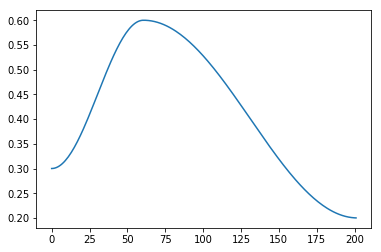

In [ ]:
learn.recorder.plot_lr()

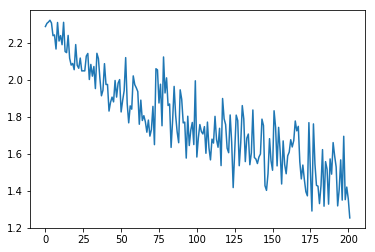

In [ ]:
learn.recorder.plot_loss()

## Export

In [ ]:
!./notebook2script.py 09b_learner.ipynb

Converted 09b_learner.ipynb to exp/nb_09b.py
